<a href="https://colab.research.google.com/github/sumit-mandal/colab_google/blob/main/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sumit-mandal/Track


Cloning into 'Track'...
remote: Enumerating objects: 14406, done.
remote: Total 14406 (delta 0), reused 0 (delta 0), pack-reused 14406
Receiving objects: 100% (14406/14406), 178.84 MiB | 41.54 MiB/s, done.
Checking out files: 100% (14503/14503), done.


In [2]:
!ls Track

#it'll show image and csv file

driving_log.csv  IMG


In [3]:
!pip install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa 
import cv2
import pandas as pd
import ntpath
import random


In [5]:
datadir = 'Track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names = columns)
#since data is oveflown i.e. written in long form(path name is long) we use pd.set_option
pd.set_option("display.max_colwidth",-1)
data.head()#to show first five columns value

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


center  ...     speed
0  E:\The Complete Self-Driving Car Course – Applied Deep Learning\14. Behavioural Cloning\data\IMG\center_2021_02_09_13_48_47_174.jpg  ...  0.000022
1  E:\The Complete Self-Driving Car Course – Applied Deep Learning\14. Behavioural Cloning\data\IMG\center_2021_02_09_13_48_47_276.jpg  ...  0.000022
2  E:\The Complete Self-Driving Car Course – Applied Deep Learning\14. Behavioural Cloning\data\IMG\center_2021_02_09_13_48_47_588.jpg  ...  0.000023
3  E:\The Complete Self-Driving Car Course – Applied Deep Learning\14. Behavioural Cloning\data\IMG\center_2021_02_09_13_48_47_690.jpg  ...  0.000024
4  E:\The Complete Self-Driving Car Course – Applied Deep Learning\14. Behavioural Cloning\data\IMG\center_2021_02_09_13_48_47_790.jpg  ...  0.000024

[5 rows x 7 columns]

In [6]:
#only showing trimmed path name
#head means from 0 , 1, 2
#tail means from 4829,4830,4831..
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2021_02_09_13_48_47_174.jpg  ...  0.000022
1  center_2021_02_09_13_48_47_276.jpg  ...  0.000022
2  center_2021_02_09_13_48_47_588.jpg  ...  0.000023
3  center_2021_02_09_13_48_47_690.jpg  ...  0.000024
4  center_2021_02_09_13_48_47_790.jpg  ...  0.000024

[5 rows x 7 columns]

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


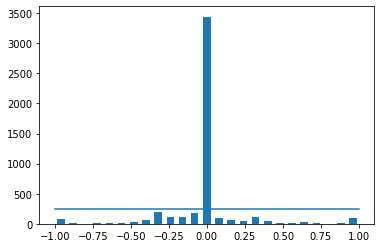

In [7]:
#for every set of image plotting steering angle in histogram 

#to create histogram first step is to divide entire range of values into intervels

num_bins = 25
samples_per_bin=250 #every bin can have maximum of 250 samples,to avoid model train at 0. as we have large amount of zeroes
hist,bins=np.histogram(data['steering'],num_bins)

#whatever values we get from steering num_bins will divide entire range into 25 intervels i.e. num_bins 
#num_bins returns two values values of histogram itself which we'll call 'hist' and intervals of bins in which our data is distributed,the interval of steering angles which we'll call bins
center = (bins[:-1]+bins[1:]) * 0.5

#putting our center value to 0 using center = (bins[:-1]+bins[1:]) * 0.5, slicing arrays to last i.e 0.92 and slicing array to first i.e. -0.92
#thus addition of -0.04 and 0.04(center values) will give zero. but it'll double everything, therfore we multiply by 0.5

print(bins)
plt.bar(center,hist,width=0.05)


plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))
#horizontal x value is min and max steering and y value is samples_per_bin
#it'll plot horizontal line uptil 200 hence we'll use this data for future refernce as we have large number of 0 values 



total data: 4834
removed: 3190
remaining: 1644


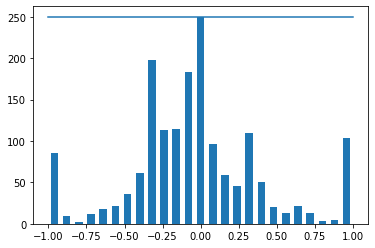

In [8]:
#making our distribution even more uniform
print('total data:', len(data))
remove_list = [] #samples which we want to remove

# we'll start by looping through every single bin

for j in range(num_bins): #for current bin j being iterated through,we'll loop through 
#  the range of every single steering angle belonging to this bin that was obtained throughout driving on the track
  list_ = []
  for i in range(len(data['steering'])): #we'll iterate through the range of all the steering data
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]: #The first thing we want to do is isolate the steering angles belong to the current bin being iterated through.

      list_.append(i) #we'll append each index of the steering angle value falling in the appropriate category to the list . steering angle is i and j is current bin
  list_ = shuffle(list_) #we shuffle beacuse data collected is in ascending order. deleting last values means deleting necessary info. 
  #therfore we shuffle so that information remains preserved
  list_ = list_[samples_per_bin:] #isolating index that goes beyond the threshold
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [9]:
#training data
print(data.iloc[1])
def load_img_steering(datadir,df): #df = data frame
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
# iloc allows us to perform a selection on a row of data,from our data frame 
# based on the specified index which will simply be the current index that's being iterated 
# through. Indexed data would therefore contain a specific row of data at each iteration.
    center,left,right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    #(os.path.join(datadir,center)) will join track/IMG/ with center_2021..
    #center.strip() will wliminate any space between the string
    steering.append(float(indexed_data[3])) #appending all the string angles

  image_paths = np.asarray(image_path) #Convert the input to an array.
  steerings = np.asarray(steering)
  return image_paths,steerings

image_paths,steerings = load_img_steering(datadir + '/IMG',data)

#recall load_img_steering is equal to track
#load_img_steering(datadir + '/IMG') will add track/ with IMG/ hence giving o/p tack/IMG

#we have two arrays image_paths array is for images and steerings is for each images containing corresponding labels





center      center_2021_02_09_13_48_51_612.jpg
left        left_2021_02_09_13_48_51_612.jpg  
right       right_2021_02_09_13_48_51_612.jpg 
steering    0                                 
throttle    1                                 
reverse     0                                 
speed       26.9249                           
Name: 40, dtype: object


In [10]:
#now splitting above arrays into random training and validation dataset

X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings,test_size=0.2,random_state=6)

#each image(X_train and X_valid) from each set of data corresponds to specific steering angle(y_train and y_valid)

f"Training Samples:{len(X_train)}  Valid Samples:{len(X_valid)}"

'Training Samples:1315  Valid Samples:329'

Text(0.5, 1.0, 'Validation set')

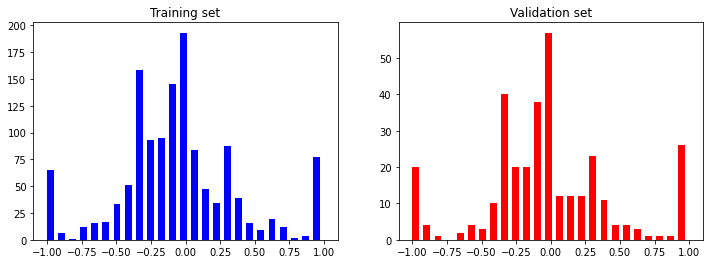

In [11]:
#to ensure both training and validation set have uniform distribution of steering angles
#such that both left and right steering angles are balanced
hist,axes = plt.subplots(1,2,figsize=(12,4)) #it has 1 row of plots and number of columns is 2. Two plots per row. Since we have differnt column values
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')


axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [12]:
#creating our own data generator

#data augmentaion techniques
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3)) #scale = range of zoom. 1 means no zoom. 1.3 means we can zoom upto 30% of our image
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed Image')

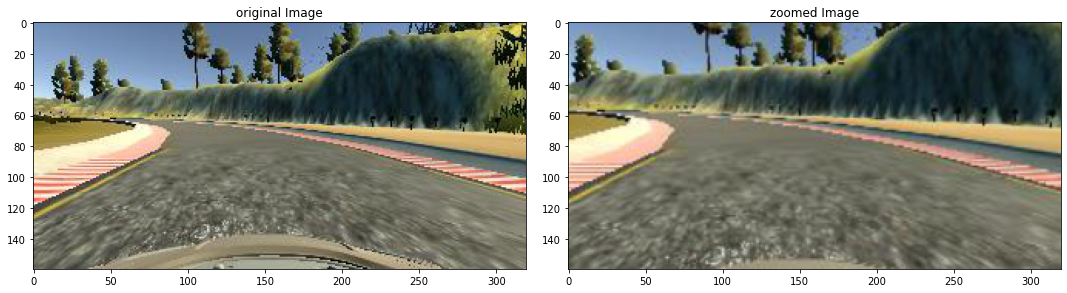

In [13]:
image = image_paths[random.randint(0,1000)] 
original_image = mpimg.imread(image) #mpimg is matplotlib.image
zoomed_image = zoom(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed Image')

In [14]:
# image panning is just horizontal or vertical translation of the image

def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1,0.1), "y": (-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'panned Image')

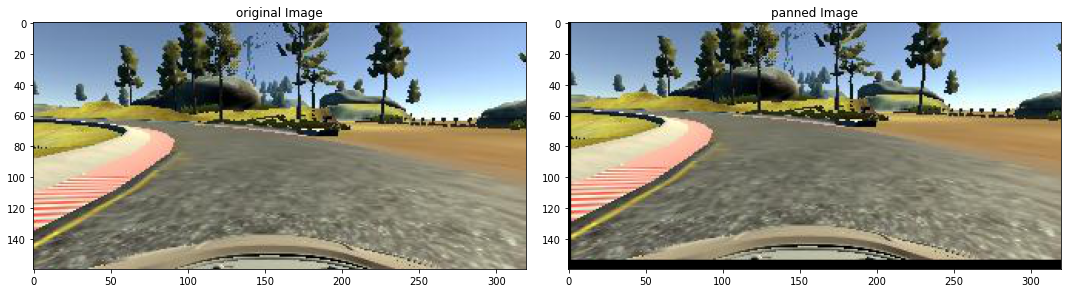

In [15]:
image = image_paths[random.randint(0,1000)] 
original_image = mpimg.imread(image) #mpimg is matplotlib.image
panned_image = pan(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("original Image")

axs[1].imshow(panned_image)
axs[1].set_title('panned Image')

In [16]:
#altering brightness
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))  #multiply function will randomly choose value b/w 0.2 to 1.2
  #(Multiply all pixel intensity in an image with a specific value.thus any pixel value multiplied by less than 1 becomes darker)
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'brightness altered Image')

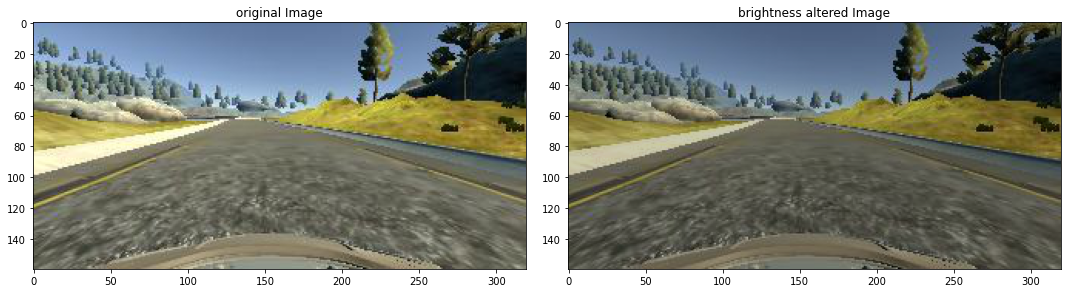

In [17]:
image = image_paths[random.randint(0,1000)] 
original_image = mpimg.imread(image) #mpimg is matplotlib.image
brightness_alterd_image = img_random_brightness(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("original Image")

axs[1].imshow(brightness_alterd_image)
axs[1].set_title('brightness altered Image')

In [18]:
# flipping- it will randoly flip our images. as we may have our datasets biased toward left turn. flipping will train the model to turn in opposite direction
#but as our car is not biased. still we'll flip as it provides additional balance

def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1) #second arguments indicates type of flip 0-vertical flip. 1-horizontal flip . -1 combination of both horizontal and vertical
  #if image is flipped steering angles should also be flipped for the augmentation to be useful for our model.
  steering_angle = -steering_angle
  return(image,steering_angle)

Text(0.5, 1.0, 'Flipped ImageSteering Angle:0.3495789')

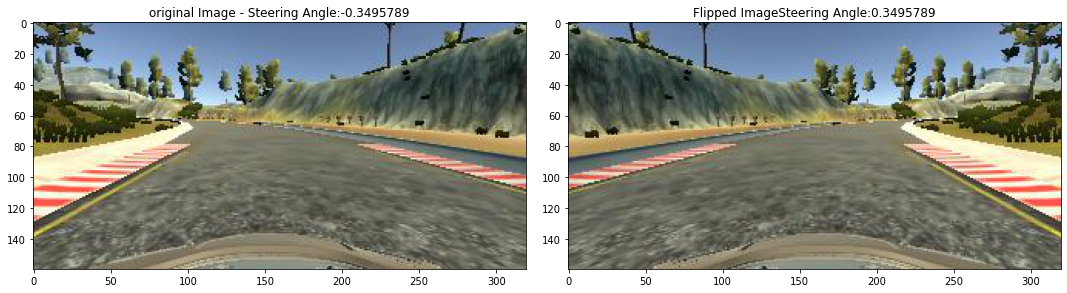

In [30]:
random_index = random.randint(0,1000)
image = image_paths[random_index] #it'll select rrandom image
steering_angle = steerings[random_index] #to select respective steering angle of choosen image

original_image = mpimg.imread(image) #mpimg is matplotlib.image
flipped_image,flipped_steering_angle = img_random_flip(original_image,steering_angle) 
#as img_random_flip returns two output we'll store them in flipped_image,flipped_steering_angle 

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image' + 'Steering Angle:' + str(flipped_steering_angle))

In [33]:
#randomsing occurence of augmentations

def random_augment(image,steering_angle): #this function first begins with reading our image path
  image = mpimg.imread(image)

  if np.random.rand() < 0.5:
    image = pan(image) #our pan function will only be applied only 50% of  the time
  if np.random.rand() < 0.5:
    image = zoom(image) #our zoomed image function will only be applied only 50% of  the time
  if np.random.rand() < 0.5:
    image = img_random_brightness(image) #our brightness function will only be applied only 50% of  the time

  if np.random.rand() < 0.5:
    image,random = img_random_flip(image,steering_angle) #our random flip function will only be applied only 50% of  the time

  return image, steering_angle

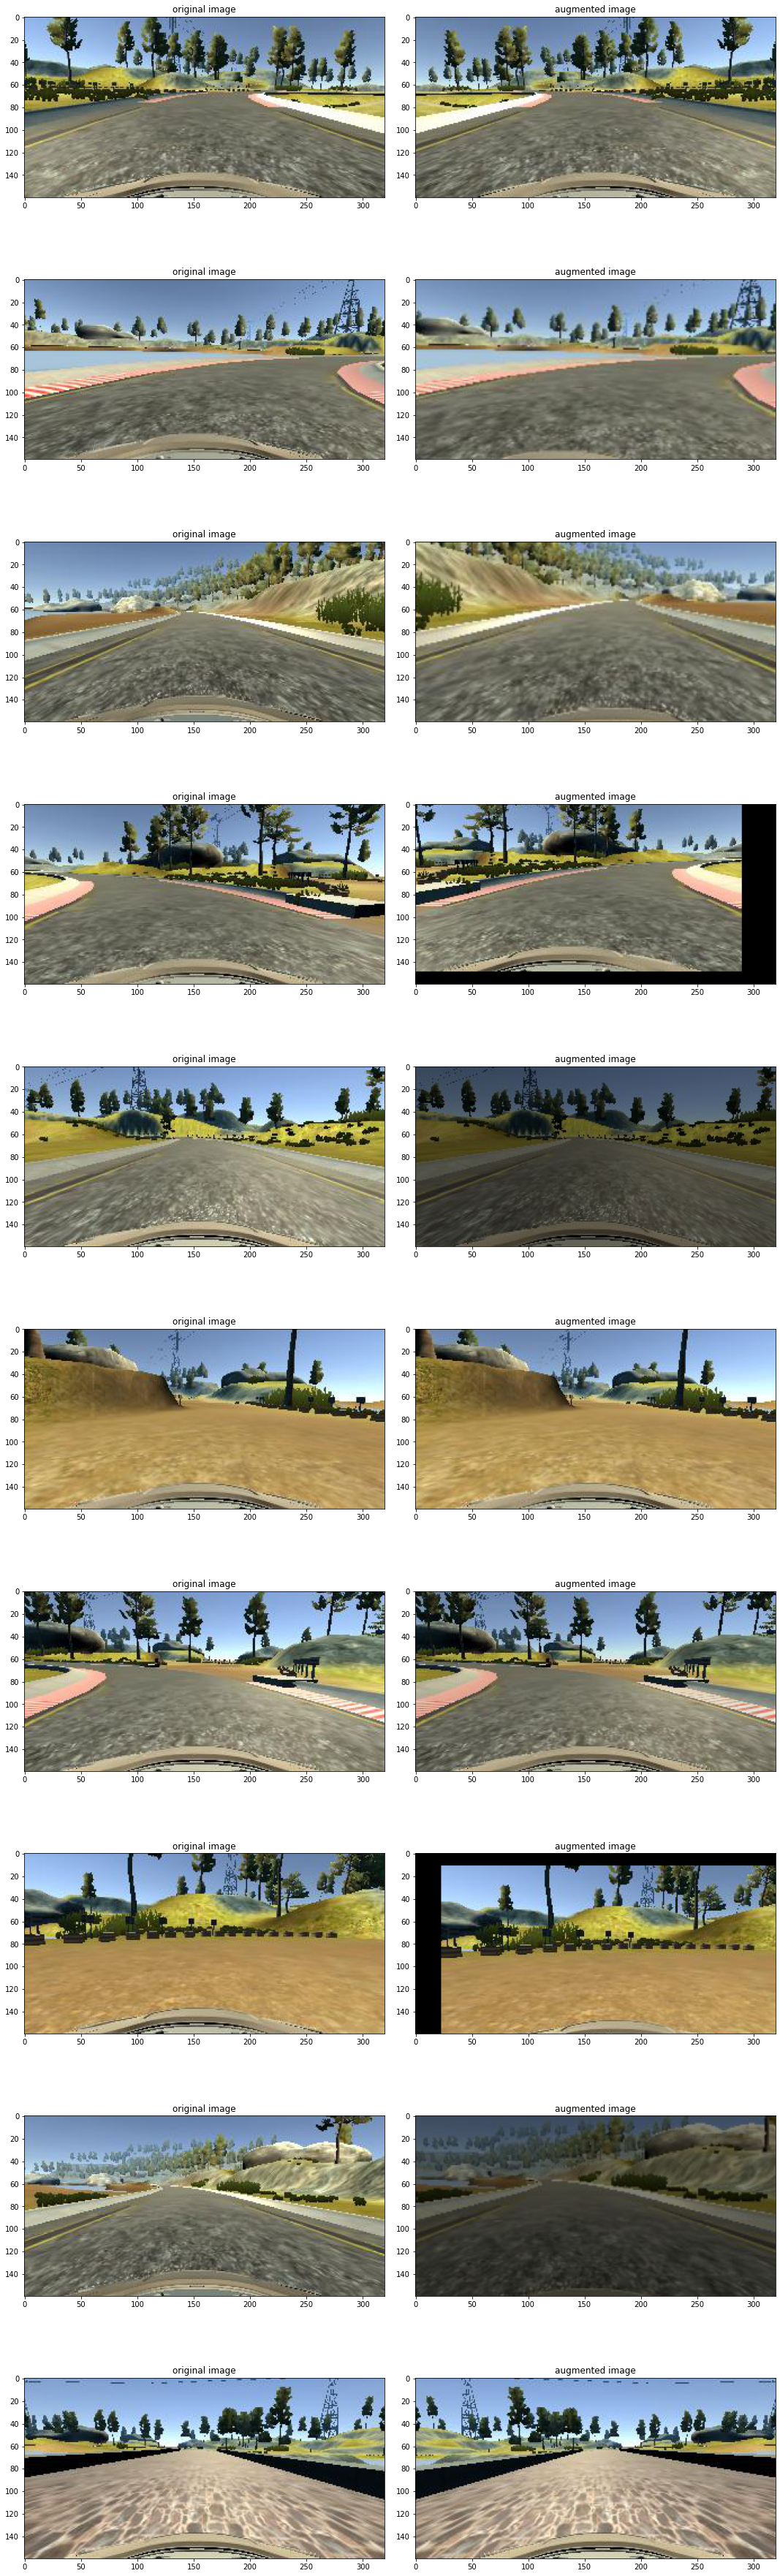

In [35]:
ncol = 2
nrow = 10 #we'll plot 10 images side by side

#original image will be plotted on left and on the right we'll have augmented image

fig, axs = plt.subplots(nrow,ncol,figsize=(15,50)) #as we are plotting 20 images in total we'll need larger fig size

fig.tight_layout() #avoid grid overlapping

for i in range(10): #for each iteration we'll select random image to augment
  randnum = random.randint(0, len(image_paths) -1) #this means that the random number returned will be used as the index 
  #value in our array to get a random image from our dataset each time.
  random_image = image_paths[randnum] #we define our random image by caliing our image paths array and feeding into it our randnum as index
  random_steering = steerings[randnum] #simialr techinque to obtain respective steering angles

  original_image = mpimg.imread(random_image) #we define original image as value read by random image path that we selected above
  augmented_image,steering = random_augment(random_image,random_steering) #we define augment image as random_augment function taken from above. 
  # we take random image as first argument and respective random steering angle as second argument. function returns augmented image aslong with flipped steering_angle. therfore we write 'steering' as variable
  
  axs[i][0].imshow(original_image) #plotting in column 0
  axs[i][0].set_title('original image')

  axs[i][1].imshow(augmented_image) #plotting in column 1
  axs[i][1].set_title('augmented image')



In [20]:
def img_preprocess(img):
  #read image path and store actual image that it contains
  img = mpimg.imread(img)

  #removing car's front part and side parts of road. as they are not important for steering angle
  img = img[60:135,:,:] #image is 3-d array whichh contains height,width and channel index. 
  #slicing height from 60 to 135

  #changing colorspace to yuv
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  #y represents the lumionisity/brightness and uv contains chromians,which adds colors to the image

  #adding gaussian blur

  img = cv2.GaussianBlur(img, (3,3), 0) #parameters - input,size,deviation 

  #Resizing image
  img = cv2.resize(img, (200, 66))

  #noramlization

  img = img/255

  return img

Text(0.5, 1.0, 'preprocessed image')

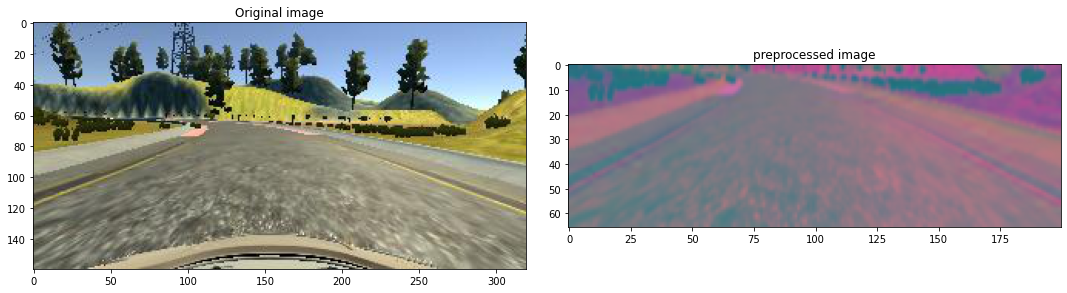

In [21]:
image = image_paths[100] #picking image at path 100 of array
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

#accessing first index of our axis objects
axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed image')





In [22]:
X_train = np.array(list(map(img_preprocess,X_train))) #it iterates through entire array and for every element in the array that it loops through returns a new element based on
#the specified function that is executed for each item in array. Ultimately creating an array with an updated value.
#we'll img_preprocess function to update each value of an array.We'll iterate through our entire X_train dataset.
#img_preprocess will return updated value of X_train.
#since map stores values in list we use list()
#np.array() allows us to get our list inside np.array

X_valid = np.array(list(map(img_preprocess,X_valid)))

(1315, 66, 200, 3)


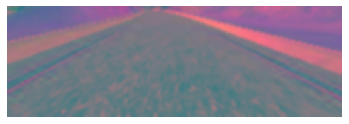

In [23]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)]) #plotting random preprocessing image 
#range of image is (0,len(X_train)-1)
plt.axis('off')
print(X_train.shape)

# output (1315, 66, 200, 3) means 3 channels with dimension of 66,200 containg 1315 image

In [24]:
#we won't use lenet model but nvidia model



def nvidia_model():
  model = Sequential()
  #starting model architecture
  #we are skinping normlalizing,(shown in architecture) because we have already normalized it
  model.add(Conv2D(24, 5, 2, input_shape = (66, 200, 3), activation = 'elu')) #nvidia model makes use of 24 filter inside this convolutional layer
# along with a kernel of 5 by 5 of the size 5 by 5. 2 is stride length. 2 means it will move 2 pixels when moving vertically and 2 pixels when moving horizontally
  
  #2nd convolution 2d layer
  model.add(Conv2D(36, 5, 2, activation = 'elu'))

  #3rd layer
  model.add(Conv2D(48, 5, 2, activation = 'elu'))

  #4th layer
  model.add(Conv2D(64, 3, activation = 'elu')) #since dimension of images have reduced from 5x5 to 3x3 we'll remove subsample

  #5th layer
  model.add(Conv2D(64, 3, activation = 'elu'))

  #earlier we used dropout layer to prevent overfitting here also we'll use that

  model.add(Dropout(0.5))


  #flatten layer 
#   this layer is going to take in our output array from our previous convolutional layer and convert it into a one dimensional array so that it can be
# fed into our fully connected layers
  model.add(Flatten())

  

  #now adding 3 dense fully connected layer
  model.add(Dense(100,activation='elu'))

  model.add(Dropout(0.5)) #droupout layer

  model.add(Dense(50,activation='elu'))
  
  model.add(Dropout(0.5)) #droupout layer

  

  model.add(Dense(10,activation='elu'))

  model.add(Dropout(0.5)) #droupout layer

  

  #output layer
  model.add(Dense(1)) #it will output the predicted steering angle for our self-driving car

  #compiling model

  optimizer = Adam(lr=1e-3) #1e-3 10^(-3)
  model.compile(loss='mse',optimizer=optimizer)

  #preventing overfitting
  return model




In [25]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [26]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid), batch_size=100,verbose=1,shuffle=1)
# Trains the model for a fixed number of epochs (iterations on a dataset).

Epoch 1/30
14/14 [==============================] - 8s 58ms/step - loss: 0.6252 - val_loss: 0.2067
Epoch 2/30
14/14 [==============================] - 0s 22ms/step - loss: 0.2826 - val_loss: 0.1958
Epoch 3/30
14/14 [==============================] - 0s 22ms/step - loss: 0.2030 - val_loss: 0.1889
Epoch 4/30
14/14 [==============================] - 0s 22ms/step - loss: 0.1777 - val_loss: 0.1807
Epoch 5/30
14/14 [==============================] - 0s 22ms/step - loss: 0.1905 - val_loss: 0.1747
Epoch 6/30
14/14 [==============================] - 0s 21ms/step - loss: 0.1812 - val_loss: 0.1732
Epoch 7/30
14/14 [==============================] - 0s 22ms/step - loss: 0.1843 - val_loss: 0.1675
Epoch 8/30
14/14 [==============================] - 0s 21ms/step - loss: 0.1674 - val_loss: 0.1619
Epoch 9/30
14/14 [==============================] - 0s 21ms/step - loss: 0.1597 - val_loss: 0.1561
Epoch 10/30
14/14 [==============================] - 0s 30ms/step - loss: 0.1508 - val_loss: 0.1495
Epoch 11/

Text(0.5, 0, 'Epoch')

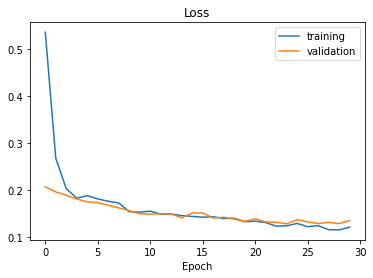

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [28]:
model.save('model.h5') #Saves the model to Tensorflow SavedModel or a single HDF5 file.



In [29]:
#downloading model
from google.colab import files
# files.download('model.h5')